<div
  style="
    padding: 36px 20px 63px 20px;
    background-color: #009ee4;
    border-radius: 0 0 200px 0;
  "
>
  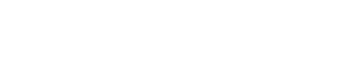

  <div
    style="
      color: white;
      margin-top: 32px;
      font-size: 56px;
      line-height: 64px;
      font-family: Arial;
    "
  >
Курсовая работа в Python 
     
  </div>
</div>



# Условие проекта

В компании SkyCrossroads есть рекламная акция, в соответствии с которой клиенту дается возможность получить дополнительные баллы лояльности за покупку, совершенную в течение ограниченного периода времени после запуска акции. 

Классическая акция подразумевает получение дополнительные 1000 баллов лояльности за покупку от 100 рублей. Было решено запустить АБ Тест, в котором в тестовой группе предлагается в два раза больше баллов лояльности за покупку от 100 рублей. 

Эксперимент был проведен в нескольких торговых точках, которые в датасете представлены столбцом id_point. Также в датасете есть информация о том, как долго клиент зарегистрирован у нас в программе лояльности.

Отдел маркетинга попросил вас рассчитать результаты этого эксперимента (в целом и в отдельности по каждой точке) и вынести решение об эффективности воздействия Б по сравнению с воздействием А. Также они хотят получить сегментацию пользователей с точки зрения из длительности регистрации.

# 1. Общий анализ АБ Теста

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import scipy.stats as stats
from scipy.stats import ttest_ind

In [3]:
#1.1. Создайте питоновский ноутбук и импортните csv файл.

df = pd.read_csv('Dataset_AB_TEST.csv', sep = ';')
df

,id_client,id_group,sum_pay,id_point,months_reg
0,1420218,test,3288.0,1199.0,8
1,1390221,control,1267.0,1182.0,11
2,1363404,control,4259.0,1178.0,2
3,1370042,test,7211.0,1179.0,3
4,1360376,control,760.0,1178.0,14
...,...,...,...,...,...
10971,1359021,control,799.0,1178.0,3
10972,1363347,control,4825.0,1178.0,6
10973,1373031,test,673.0,1179.0,1
10974,1370292,test,1120.0,1179.0,1


**Расшифровка данных:**

**id_client** - уникальный id клиента

**id_group** - контроль (1000 баллов лояльности) / тест (2000 баллов лояльности)

**sum_pay** - сумма, на которую была совершена покупка

**id_point** - id торговой точки

**months_reg** - длительность регистрации клиента в программе лояльности

In [4]:
#1.2. Проведите очистку данных от нуллов и выбросов (используйте функцию ***statistical_analysis***).

# Очистка данных от нуллов
df_clean = df.dropna()
df_clean

,id_client,id_group,sum_pay,id_point,months_reg
0,1420218,test,3288.0,1199.0,8
1,1390221,control,1267.0,1182.0,11
2,1363404,control,4259.0,1178.0,2
3,1370042,test,7211.0,1179.0,3
4,1360376,control,760.0,1178.0,14
...,...,...,...,...,...
10971,1359021,control,799.0,1178.0,3
10972,1363347,control,4825.0,1178.0,6
10973,1373031,test,673.0,1179.0,1
10974,1370292,test,1120.0,1179.0,1


In [5]:
#Поиск выбросов

months_reg
0      795
1      798
2     1352
3     1690
4     1078
5     1205
6     1245
7      652
8      669
9      312
10     329
11     335
12     219
13      78
14      83
Name: id_client, dtype: int64

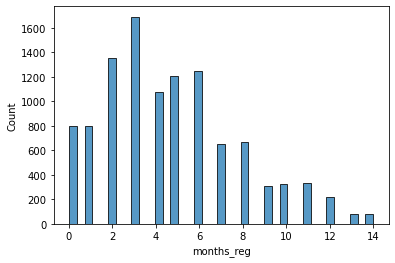

In [6]:
# Группировка по длительности регистрации клиента в программе лояльности
sns.histplot(df_clean['months_reg'])
df_clean.groupby('months_reg')['id_client'].count()

id_group
control    5171
test       5669
Name: id_client, dtype: int64

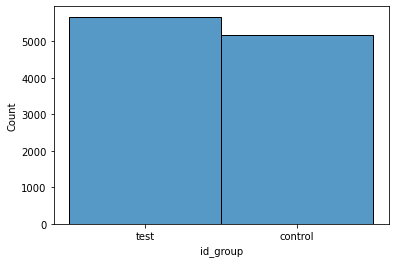

In [7]:
# Группировка по Тест- и Контроль-группам
sns.histplot(df_clean['id_group'])
df_clean.groupby('id_group')['id_client'].count()

sum_pay
59.0       1
65.0       1
67.0       1
73.0       1
75.0       1
          ..
24618.0    1
24645.0    1
24761.0    1
24784.0    1
24797.0    1
Name: id_client, Length: 5915, dtype: int64

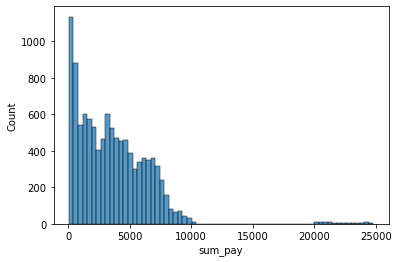

In [8]:
# Суммы оплат клиентов и гистограмма распределения сумм, на которые были совершены покупки.
sns.histplot(df_clean['sum_pay'])
df_clean.groupby('sum_pay')['id_client'].count()

In [9]:
# Группировка уникальных покупателей по торговым точкам.
df_clean.groupby('id_point')['id_client'].count()

id_point
1178.0    4810
1179.0    3471
1182.0    2010
1186.0      63
1188.0      10
1199.0     476
Name: id_client, dtype: int64

In [10]:
# Выбросы обнаружены в 'sum_pay'.

,id_client,id_group,sum_pay,id_point,months_reg
0,1420218,test,3288.0,1199.0,8
1,1390221,control,1267.0,1182.0,11
2,1363404,control,4259.0,1178.0,2
3,1370042,test,7211.0,1179.0,3
4,1360376,control,760.0,1178.0,14
...,...,...,...,...,...
10971,1359021,control,799.0,1178.0,3
10972,1363347,control,4825.0,1178.0,6
10973,1373031,test,673.0,1179.0,1
10974,1370292,test,1120.0,1179.0,1


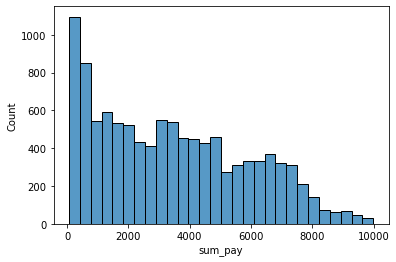

In [11]:
# Очистим данные от выбросов.
df_clean = df_clean.loc[df_clean['sum_pay'] < 10000]
sns.histplot(df_clean['sum_pay'])
df_clean

In [165]:
#1.3. Проведите визуализацию с помощью гистограммы для сравнения результатов в А и Б группе (имеет смысл создать отдельную функцию для визуализации ***show_hist***).

# Фильтр по Тест-группе
id_group_test = df_clean.loc[df_clean['id_group'] == 'test']
# id_group_test

In [166]:
# Фильтр по Контроль-группе
id_group_control = df_clean.loc[df_clean['id_group'] == 'control']
# id_group_control

In [173]:
# Функция визуализации
def show_hist(r1, r2):
    min_size = min(len(r1),len(r2))
    sns.histplot(r1.sample(min_size), label='Тест-группа')
    sns.histplot(r2.sample(min_size), color = 'coral', label='Контроль-группа')
    plt.legend()
    plt.show()
    
# в функции
# show_hist(id_group_test['sum_pay'], id_group_control['sum_pay'])
# show_hist(id_group_test['months_reg'], id_group_control['months_reg'])

In [174]:
# Функция для поиска среднего, дисперсии и стандартного отклонения.

def sum_pay_test(id_group_test, id_group_control):
    # sum_pay_test
    mean_sum_pay_test = id_group_test.mean()
    var_sum_pay_test = id_group_test.var()
    std_sum_pay_test = id_group_test.std()

    # sum_pay_control
    mean_sum_pay_control = id_group_control.mean()
    var_sum_pay_control = id_group_control.var()
    std_sum_pay_control = id_group_control.std()

    print("Средняя сумма покупки в Тест-группе:", mean_sum_pay_test.sum_pay)
    print("Средняя сумма покупки в Контроль-группе:", mean_sum_pay_control.sum_pay)
    print(' ')
    print("Средняя длительность регистрации клиента в программе лояльности в Тест-группе:", mean_sum_pay_test.months_reg)
    print("Средняя длительность регистрации клиента в программе лояльности в Контроль-группе:", mean_sum_pay_control.months_reg)
    print('')

    print('---------------------------')


    print("Дисперсия суммы покупки в Тест-группе:", var_sum_pay_test.sum_pay)
    print("Дисперсия суммы покупки в Контроль-группе:", var_sum_pay_control.sum_pay)
    print(' ')
    print("Дисперсия длительности регистрации клиента в программе лояльности в Тест-группе:", var_sum_pay_test.months_reg)
    print("Дисперсия длительности регистрации клиента в программе лояльности в Контроль-группе:", var_sum_pay_control.months_reg)
    print('')

    print('---------------------------')


    print("Стандартное отклонение суммы покупки в Тест-группе:", std_sum_pay_test.sum_pay)
    print("Стандартное отклонение суммы покупки в Контроль-группе:", std_sum_pay_control.sum_pay)
    print(' ')
    print("Стандартное отклонение регистрации клиента в программе лояльности в Тест-группе:", std_sum_pay_test.months_reg)
    print("Стандартное отклонение регистрации клиента в программе лояльности в Контроль-группе:", std_sum_pay_control.months_reg)

# в функции
# sum_pay_test(id_group_test, id_group_control)

#пример исп-ия
#print('id_point 1178')
# sum_pay_test(id_group_test.loc[id_group_test['id_point'] == 1178], id_group_control.loc[id_group_control['id_point'] == 1178])
#print('')
#print('-------------------')

In [175]:
# 1.4. Посмотрите на результаты параметрического и непараметрического теста (используйте функции ***mann_whitney_func*** и ***test_calc***).

In [176]:
# Mann_whitney_func

def mann_whitney_func(r1, r2, alpha=0.05):
    mannwhitney, pvalue = stats.mannwhitneyu(r1, r2 , alternative = 'less')

    if (pvalue > alpha):
        print('Распределения равны')
    else:
        print('Распределения не равны')  
    print(' ')
    print('----------------')

# в функции
# print('Манн-Уитни по суммам, на которые была совершена покупка в Тест- и Контроль-группах')    
# mann_whitney_func(id_group_test['sum_pay'], id_group_control['sum_pay'])

In [177]:
# T-test (для сравнения средних)

def ttest(r1, r2):
    statistic,pvalue = stats.ttest_ind(r1, r2)
    alpha=0.05
    print('T-test')  
    if (pvalue > alpha):
        print('Средние распределений равны')
    else:
        print('Средние распределений не равны')
        
    print(statistic, pvalue)
    print(' ')
    print('----------------')

# в функции
# ttest(id_group_control['sum_pay'], id_group_test['sum_pay'])

In [178]:
#test_calc

def test_calc(r1, r2, alpha=0.05):
    s,p = ttest_ind(r1, r2)
#     print(s)
#     print(p)
    print('test_calc')     
    if (p < alpha):
        print ('Нулевая гипотеза принимается')
    else:
        print ('Нулевая гипотеза не принимается')
    return s,p

    print(' ')
    print('----------------')
 
    # в функции
# test_calc(id_group_test['sum_pay'], id_group_control['sum_pay'])

In [179]:
def AB_analisys(id_group_test, id_group_control):

# Функция визуализации
    show_hist(id_group_test['sum_pay'], id_group_control['sum_pay']) #контроль - корал
    show_hist(id_group_test['months_reg'], id_group_control['months_reg'])
    
# Функция для поиска среднего, дисперсии и стандартного отклонения.    
    sum_pay_test(id_group_test, id_group_control)

# Mann_whitney_func
    print('----------------')
    print('Манн-Уитни по суммам, на которые была совершена покупка в Тест- и Контроль-группах')    
    mann_whitney_func(id_group_test['sum_pay'], id_group_control['sum_pay'])

# T-test (для сравнения средних)    
    ttest(id_group_control['sum_pay'], id_group_test['sum_pay'])
    
#test_calc    
    test_calc(id_group_test['sum_pay'], id_group_control['sum_pay'])

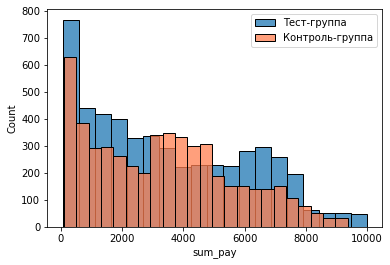

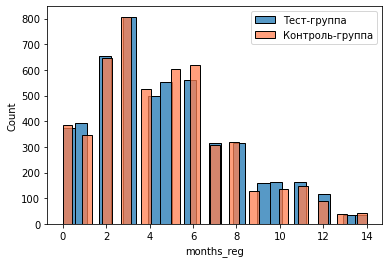

Средняя сумма покупки в Тест-группе: 3497.8294684266857
Средняя сумма покупки в Контроль-группе: 3339.535408560311
 
Средняя длительность регистрации клиента в программе лояльности в Тест-группе: 4.7112022832679274
Средняя длительность регистрации клиента в программе лояльности в Контроль-группе: 4.651167315175098

---------------------------
Дисперсия суммы покупки в Тест-группе: 6617248.620333984
Дисперсия суммы покупки в Контроль-группе: 5253689.135348443
 
Дисперсия длительности регистрации клиента в программе лояльности в Тест-группе: 10.335671096630156
Дисперсия длительности регистрации клиента в программе лояльности в Контроль-группе: 9.699852694319596

---------------------------
Стандартное отклонение суммы покупки в Тест-группе: 2572.4013334497367
Стандартное отклонение суммы покупки в Контроль-группе: 2292.0927414370567
 
Стандартное отклонение регистрации клиента в программе лояльности в Тест-группе: 3.214913855242494
Стандартное отклонение регистрации клиента в программе л

C:\Users\snyat\AppData\Local\Temp/ipykernel_14784/1530103330.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean_sum_pay_test = id_group_test.mean()
C:\Users\snyat\AppData\Local\Temp/ipykernel_14784/1530103330.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  var_sum_pay_test = id_group_test.var()
C:\Users\snyat\AppData\Local\Temp/ipykernel_14784/1530103330.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  std_sum_pay_test = id_group_test.std()
C:\Users\snyat\AppData\Local\Tem

In [180]:
AB_analisys(id_group_test, id_group_control)

1.5. Сделайте выводы.

На основании статистического анализа, можно сделать выводы, что внедрение новой системы лояльности целесообразно и принесет дополнительный доход.

# 2. Анализ по торговым точкам
        
2.1. Создайте цикл, пробегающий по всем уникальным торговым точкам.
        
2.2. Для каждой торговой точки проведите визуализацию с помощью гистограммы для сравнения результатов в А и Б группе (используйте функцию ***show_hist).***
        
2.3. Для каждой торговой точки посмотрите на результаты параметрического и непараметрического теста (используйте функции ***mann_whitney_func*** и ***test_calc***).
        
2.4. Для каждой торговой точки сделайте выводы.
        
2.5. Убедитесь, что в торговых точках, по которым вы делаете выводы, достаточное количество наблюдений.
        
**Важно! При анализе воспользуйтесь функциями, которые вы создали в домашних заданиях в курсе статистики**

In [182]:
id_group_control.groupby('id_point')['id_client'].count()

id_point
1178.0    2403
1179.0    1697
1182.0    1012
1186.0      23
1188.0       5
Name: id_client, dtype: int64

In [183]:
id_group_test.groupby('id_point')['id_client'].count()

id_point
1178.0    2406
1179.0    1745
1182.0     935
1186.0      40
1188.0       4
1199.0     476
Name: id_client, dtype: int64

In [184]:
# Фильтр по Торговым точкам
id_point_1178_control = id_group_control.loc[id_group_control['id_point'] == 1178.0]
id_point_1178_test = id_group_test.loc[id_group_test['id_point'] == 1178.0]

id_point_1179_control = id_group_control.loc[id_group_control['id_point'] == 1179.0]
id_point_1179_test = id_group_test.loc[id_group_test['id_point'] == 1179.0]

id_point_1182_control = id_group_control.loc[id_group_control['id_point'] == 1182.0] 
id_point_1182_test = id_group_test.loc[id_group_test['id_point'] == 1182.0]

# В выборке недостаточное количество наблюдений.
# id_point_1186_control = id_group_control.loc[id_group_control['id_point'] == 1186.0] 
# id_point_1186_test = id_group_test.loc[id_group_test['id_point'] == 1186.0]

# В выборке недостаточное количество наблюдений.
# id_point_1188_control = id_group_control.loc[id_group_control['id_point'] == 1188.0] 
# id_point_1188_test = id_group_test.loc[id_group_test['id_point'] == 1188.0]

# Контрольные данные отсутствуют, в даьнейшем анализе не учитывается.
# id_point_1199_control = id_group_control.loc[id_group_control['id_point'] == 1199.0] 
# id_point_1199_test = id_group_test.loc[id_group_test['id_point'] == 1199.0]

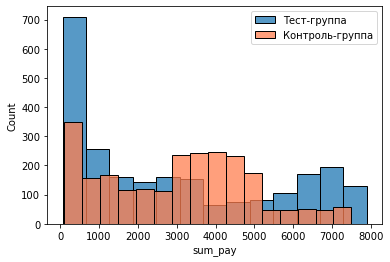

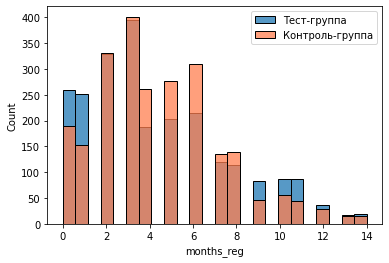

Средняя сумма покупки в Тест-группе: 2936.386949293433
Средняя сумма покупки в Контроль-группе: 3036.214731585518
 
Средняя длительность регистрации клиента в программе лояльности в Тест-группе: 4.330423940149626
Средняя длительность регистрации клиента в программе лояльности в Контроль-группе: 4.407407407407407

---------------------------
Дисперсия суммы покупки в Тест-группе: 6589788.719646659
Дисперсия суммы покупки в Контроль-группе: 3592781.4576180275
 
Дисперсия длительности регистрации клиента в программе лояльности в Тест-группе: 11.242541774461673
Дисперсия длительности регистрации клиента в программе лояльности в Контроль-группе: 8.617880161593943

---------------------------
Стандартное отклонение суммы покупки в Тест-группе: 2567.058378698595
Стандартное отклонение суммы покупки в Контроль-группе: 1895.4633886250685
 
Стандартное отклонение регистрации клиента в программе лояльности в Тест-группе: 3.352989975299907
Стандартное отклонение регистрации клиента в программе лоя

C:\Users\snyat\AppData\Local\Temp/ipykernel_14784/1530103330.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean_sum_pay_test = id_group_test.mean()
C:\Users\snyat\AppData\Local\Temp/ipykernel_14784/1530103330.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  var_sum_pay_test = id_group_test.var()
C:\Users\snyat\AppData\Local\Temp/ipykernel_14784/1530103330.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  std_sum_pay_test = id_group_test.std()
C:\Users\snyat\AppData\Local\Tem

In [185]:
# АВ тест по торговой точке 1178
AB_analisys(id_point_1178_test, id_point_1178_control)

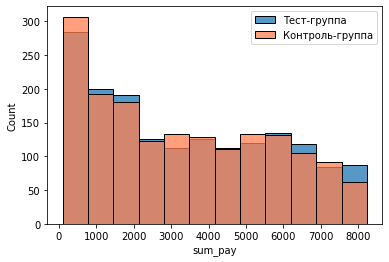

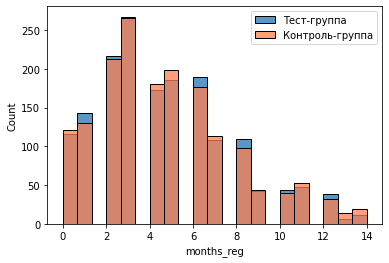

Средняя сумма покупки в Тест-группе: 3421.826934097421
Средняя сумма покупки в Контроль-группе: 3331.3105480259283
 
Средняя длительность регистрации клиента в программе лояльности в Тест-группе: 4.587392550143266
Средняя длительность регистрации клиента в программе лояльности в Контроль-группе: 4.6599882144961695

---------------------------
Дисперсия суммы покупки в Тест-группе: 5680420.067508074
Дисперсия суммы покупки в Контроль-группе: 5504638.724847396
 
Дисперсия длительности регистрации клиента в программе лояльности в Тест-группе: 9.585391419783807
Дисперсия длительности регистрации клиента в программе лояльности в Контроль-группе: 10.136092688540314

---------------------------
Стандартное отклонение суммы покупки в Тест-группе: 2383.3631841387655
Стандартное отклонение суммы покупки в Контроль-группе: 2346.1966509326103
 
Стандартное отклонение регистрации клиента в программе лояльности в Тест-группе: 3.096028329938828
Стандартное отклонение регистрации клиента в программе л

C:\Users\snyat\AppData\Local\Temp/ipykernel_14784/1530103330.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean_sum_pay_test = id_group_test.mean()
C:\Users\snyat\AppData\Local\Temp/ipykernel_14784/1530103330.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  var_sum_pay_test = id_group_test.var()
C:\Users\snyat\AppData\Local\Temp/ipykernel_14784/1530103330.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  std_sum_pay_test = id_group_test.std()
C:\Users\snyat\AppData\Local\Tem

In [186]:
# АВ тест по торговой точке 1179
AB_analisys(id_point_1179_test, id_point_1179_control)

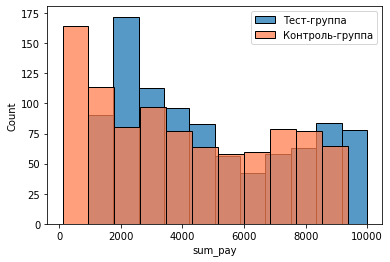

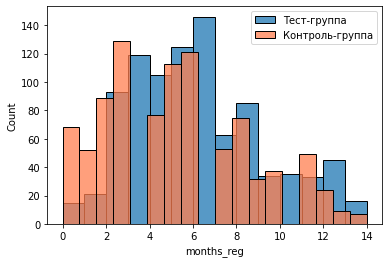

Средняя сумма покупки в Тест-группе: 4862.9508021390375
Средняя сумма покупки в Контроль-группе: 4036.9426877470355
 
Средняя длительность регистрации клиента в программе лояльности в Тест-группе: 5.754010695187166
Средняя длительность регистрации клиента в программе лояльности в Контроль-группе: 5.16699604743083

---------------------------
Дисперсия суммы покупки в Тест-группе: 7394082.725628376
Дисперсия суммы покупки в Контроль-группе: 8003779.804822831
 
Дисперсия длительности регистрации клиента в программе лояльности в Тест-группе: 9.33128743029237
Дисперсия длительности регистрации клиента в программе лояльности в Контроль-группе: 11.021540720063504

---------------------------
Стандартное отклонение суммы покупки в Тест-группе: 2719.2062675766942
Стандартное отклонение суммы покупки в Контроль-группе: 2829.095227245423
 
Стандартное отклонение регистрации клиента в программе лояльности в Тест-группе: 3.054715605468432
Стандартное отклонение регистрации клиента в программе лоял

C:\Users\snyat\AppData\Local\Temp/ipykernel_14784/1530103330.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean_sum_pay_test = id_group_test.mean()
C:\Users\snyat\AppData\Local\Temp/ipykernel_14784/1530103330.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  var_sum_pay_test = id_group_test.var()
C:\Users\snyat\AppData\Local\Temp/ipykernel_14784/1530103330.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  std_sum_pay_test = id_group_test.std()
C:\Users\snyat\AppData\Local\Tem

In [187]:
# АВ тест по торговой точке 1182
AB_analisys(id_point_1182_test, id_point_1182_control)

Выводы:

На основании проведенного анализа, гипотеза принимаетмя только на торговой точке 1182. Следовательно, на торговой точке 1182 введение новой системы лояльности целесообразно.

# 3. Сегментация по длительности регистрации

3.1. Рассмотрите два вида корреляции между выплаченной суммой и длительностью регистрации.
        
3.2. Как полученные результаты повлияют на ваши бизнес-рекомендации?
        
**Важно! При анализе воспользуйтесь функциями, которые вы создали в домашних заданиях в курсе статистики**

In [192]:
# df_clean
# id_group_test
# id_group_control

In [189]:
# Корреляция Пирсона и Спирмена

def proxi_ranges(r1, r2, alpha=0.05):
    var_r1 = np.var(r1)
    var_r2 = np.var(r2)    
    cov_r1 = np.cov(r1)
    cov_r2 = np.cov(r2)
    corrcoef_array = np.corrcoef(r1, r2)
    corrcoef = corrcoef_array[0][1]
    spearmanr, pvalue = stats.spearmanr(r1, r2)

#     print(var_r1)
#     print(var_r2)
#     print(cov_r1)
#     print(cov_r2)
#     print(corrcoef)  
#     print(spearmanr)
#     print(pvalue)
    print(' ')
    print('Корреляция Пирсона:')
    if (pvalue > alpha):
        print('Корреляция равна нулю')
    else:
        if ((corrcoef) < 0):
            print('Кореляция отрицательная')
        if (abs(corrcoef) < 0.3):
            print ('Корреляция слабая')           
        elif (abs(corrcoef) < 0.7):
            print ('Корреляция средняя')
        elif (abs(corrcoef) > 0.7):        
            print ('Корреляция сильная')
            
    print(' ')     
    print('Корреляция Спирмена:')
    if (pvalue > alpha):
        print('Корреляция равна нулю')
    else:
        if ((spearmanr) < 0):
            print('Кореляция отрицательная')
        if (abs(spearmanr) < 0.3):
            print ('Корреляция слабая')
        elif (abs(spearmanr) < 0.7):
            print ('Корреляция средняя')
        elif (abs(spearmanr) > 0.7):        
            print ('Корреляция сильная')

proxi_ranges(df_clean['sum_pay'], df_clean['months_reg'])
# print('----------------')  
# print('Тест-группа.')
# proxi_ranges(id_group_test['sum_pay'], id_group_test['months_reg'])
# print('----------------')
# print('Контроль-группа.')
# proxi_ranges(id_group_control['sum_pay'], id_group_control['months_reg'])

 
Корреляция Пирсона:
Корреляция средняя
 
Корреляция Спирмена:
Корреляция средняя


Зависимость между суммой выплат и длительностью регистрации прямопропорциональна. Корреляция средняя. На основе этого, можно сделать вывод, что увеличение выплаченной суммы приведет к удержанию клиентов.

<!-- # ![image.png](attachment:image.png)  -->

<!-- ![og_og_1476731219265114373.jpg](attachment:og_og_1476731219265114373.jpg) -->